# Testing the occultence package

In [2]:
from occultence import *
from nuance import utils

Generate (fake) lightcurve:

(0.99, 1.012)

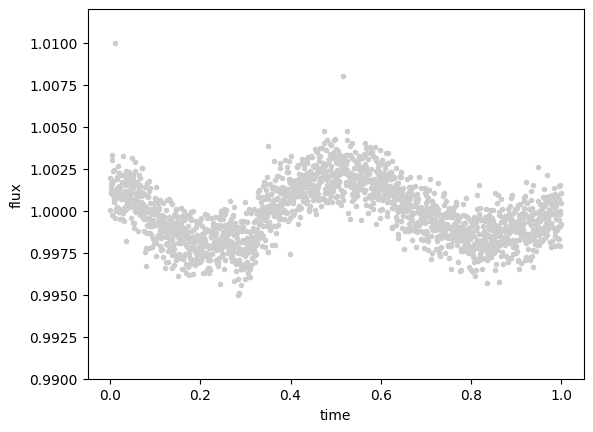

In [22]:
# t = np.linspace(0.5,0.9,200)
# ferr = 2e-3 * np.ones(len(t))
# f = 1 + (ferr * (np.random.randn(len(t))))
# f[22] = 1.01 # add a cosmic
# f[63] = 1.008 # add a cosmic
# f[50] = 0.0 # add a zero flux point
# f[100:120] *= 0.995 # add a transit
# f *= 1.0-(0.08 * (t-t[0])**2) #np.linspace(1,1.01, len(t)) # add a quadratic trend for the GP to remove
# plt.figure(figsize=(12,4))
# plt.errorbar(t,f,ferr,fmt='k.')
# plt.ylim(0.98,1.015)

t = np.linspace(0, 1, 2000)
true = {"t0": 0.3, "D": 0.05, "P": 10, "depth": 1e-3}
(t, f, ferr), X, gp = utils.simulated(t=t, **true)
ferr = [ferr] * len(t)
f = f.at[22].set(1.01) # add a cosmic
f = f.at[1030].set(1.008) # add a cosmic
# f = f.at[130].set(0.008) # add a zero flux point
f = np.array(f)
plt.plot(t, f, ".", c="0.8")
plt.ylabel("flux")
plt.xlabel("time")
plt.ylim(0.99,1.012)

## Create LightCurve object

In [23]:
targ = LightCurve(name = "test",
                  time = t,
                  flux = f,
                  uncertainty = np.abs(ferr))

🌈🤖 Warning! The time array is not an astropy.Time object, therefore there is no info about the 
format or scale.
We will assume that it is JD and TDB from here on!



In [24]:
targ

<🌟 Lightcurve test (2000t) 🌟>

In [25]:
# targ.__dict__

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


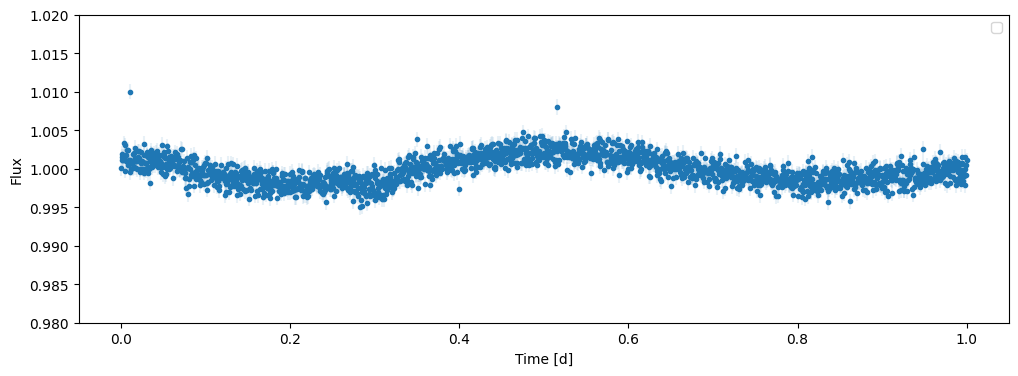

In [26]:
targ.plot();

## Clean LightCurve

In [27]:
clean_targ = targ.clean(dust_removal=False, bad_weather_removal=True, cosmics_removal=True, cosmic_boxsize=0.08, cosmic_nsigma=3)

/Users/catrionamurray/anaconda3/envs/occultence/lib/python3.9/site-packages/occultence/cleaning/clean.py:77: UserWarning:  The LightCurve's timelike dictionary does not appear to have the 'artifical_lightcurve' in it.
                 This array is necessary to calculate bad weather, therefore this will ** not ** be applied!
  warnings.warn(f""" The LightCurve's timelike dictionary does not appear to have the 'artifical_lightcurve' in it.


In [28]:
# targ.masks

In [29]:
bin_targ = clean_targ.bin(dt= 20 * u.minute)

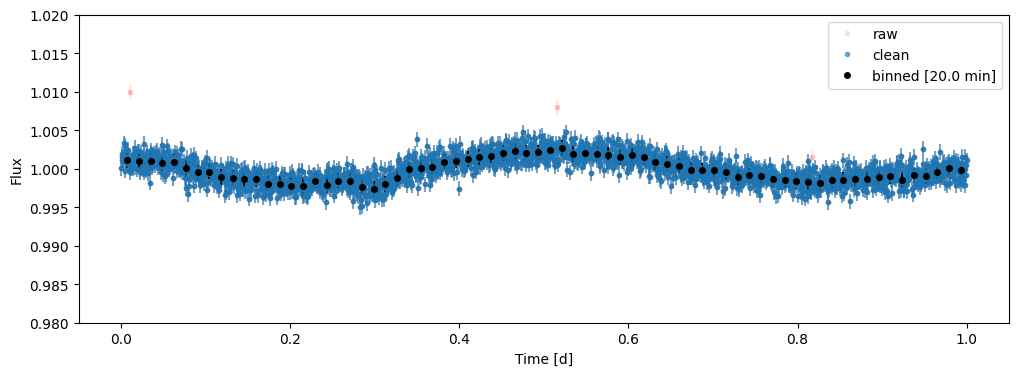

In [30]:
ax = targ.plot(alpha=0.1, label='raw', color='red', alpha_error=0.1, zorder=0)
ax = clean_targ.plot(ax=ax, alpha=0.6, alpha_error=0.6, label="clean")
bin_targ.plot(ax=ax, label=f"binned [{bin_targ.time_bin_size[0]}]", color='k', markersize=8, alpha_error=1.0);

/Users/catrionamurray/anaconda3/envs/occultence/lib/python3.9/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Fitting rotation with quasi-periodic GP, period = 0.6d...
Initial Parameter Vector:  [-6.90775528 -6.57716243 -0.69314718 10.         -0.51082562]
Initial Params: AMP =  0.0013917930065607193 , SQEXP=  0.5 , GAMMA=  10.0 , Period =  0.6  days , JITTER =  0.0010000000000000002
Initial ln-likelihood: 162.94
Fitted GP HPs: [-32.69779064 -12.83675373  -3.83094095  29.87952768   4.07191516]
Fitted Params: AMP =  2.6611459184607314e-06 , SQEXP=  0.021689197627194047 , GAMMA=  29.879527684842948 , Period =  58.669216101498286  days , JITTER =  6.30274814374059e-15
Final ln-likelihood: 402.91


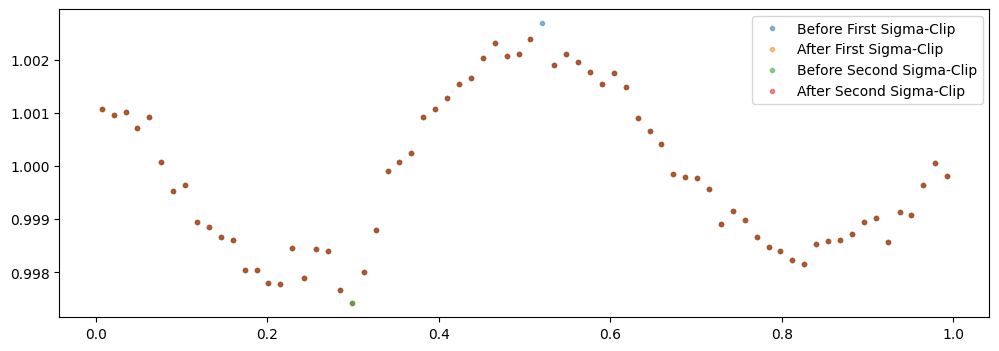

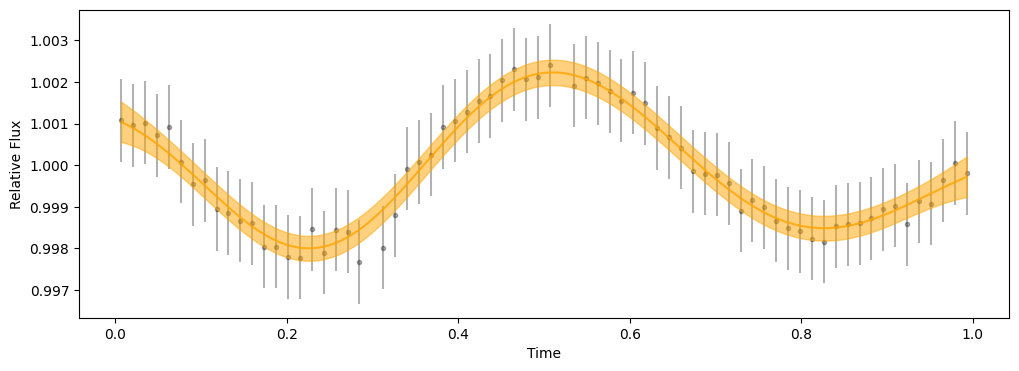

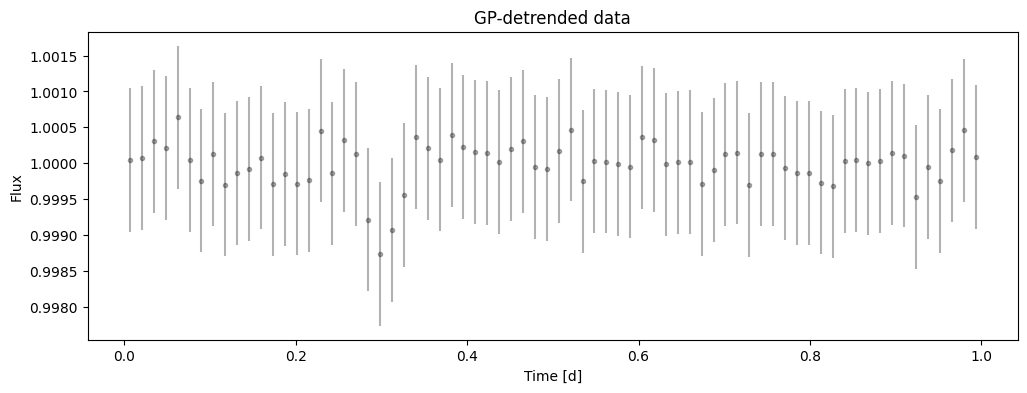

In [41]:
gp_targ = bin_targ.gp_detrend(do_first_sigma_clip=True, do_second_sigma_clip=True, running_mean_boxsize=0.08, nsigma=2, plot=True,
                              rotation_period=0.6, rotation_amp=10**1, verbose=True)

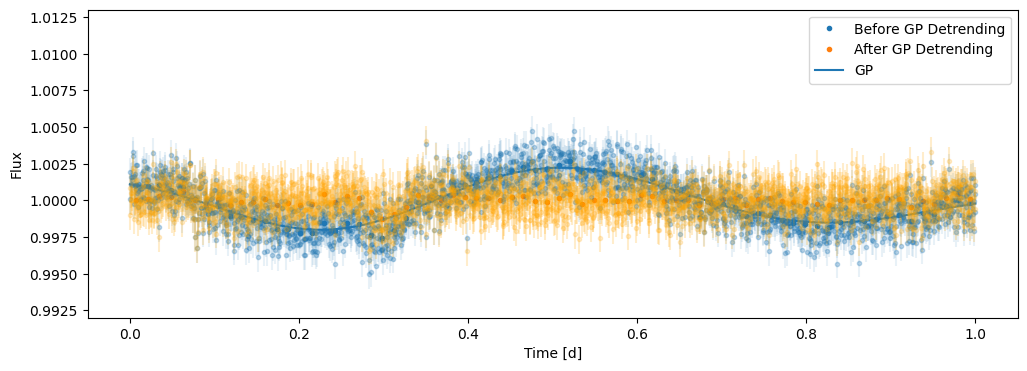

In [42]:
ax=bin_targ.plot(label="Before GP Detrending", color='C0');
gp_targ.plot(ax=ax, label="After GP Detrending", color='C1');
clean_targ.plot(ax=ax, color='C0', alpha=0.2)
# we can also predict the GP for different time resolutions
gp_full_res = 1+gp_targ.metadata['gp'].predict(y=gp_targ.metadata['data_to_condition_gp'], t=clean_targ.time.value)[0]
plt.plot(clean_targ.time.value, gp_full_res, label='GP', c='C0')
plt.errorbar(clean_targ.time.value, clean_targ.flux/gp_full_res, clean_targ.uncertainty, fmt='.', color='orange', alpha=0.2);
plt.ylim(0.992,1.013)
plt.legend()

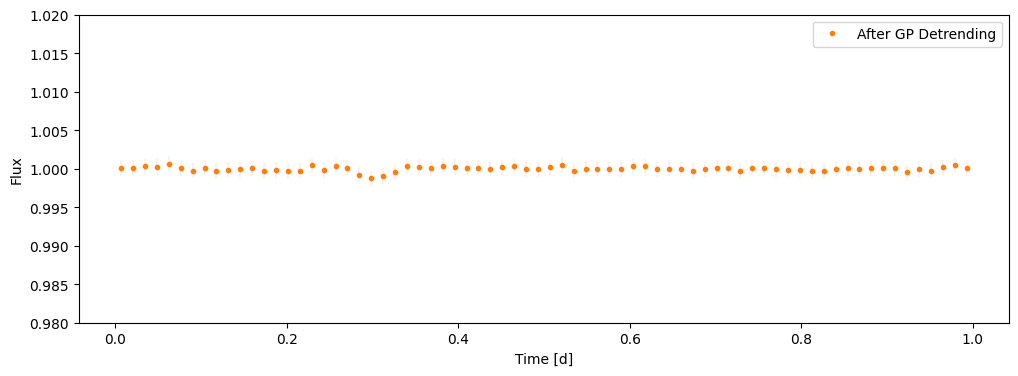

In [43]:
gp_targ.plot(label="After GP Detrending", color='C1');

## Find transits!

In [59]:
# we can also predict the GP for 7.5 min binning and use that for the BLS
bin_targ = clean_targ.bin(dt=2*u.minute)
gp_model = 1 + \
               gp_targ.metadata['gp'].predict(y=gp_targ.metadata['data_to_condition_gp'], t=bin_targ.time.value)[0]
gp_smaller_binning = bin_targ._create_copy()
gp_smaller_binning.timelike['flux'] = gp_smaller_binning.timelike['flux'] / gp_model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='Time [d]', ylabel='Flux'>

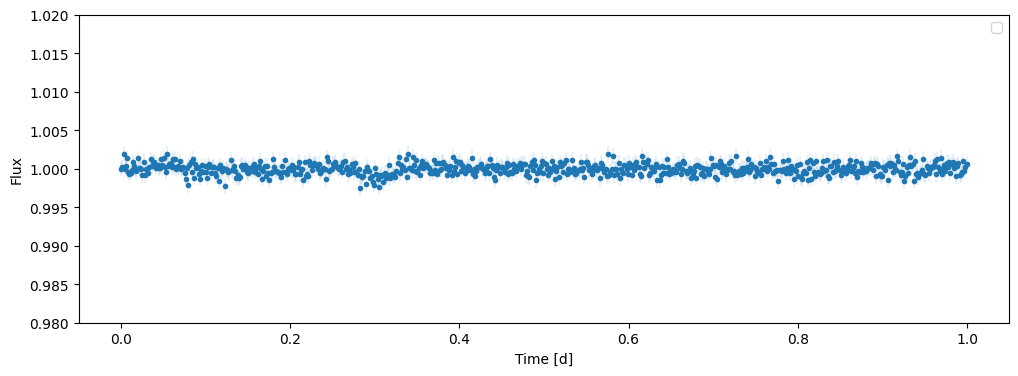

In [60]:
gp_smaller_binning.plot()

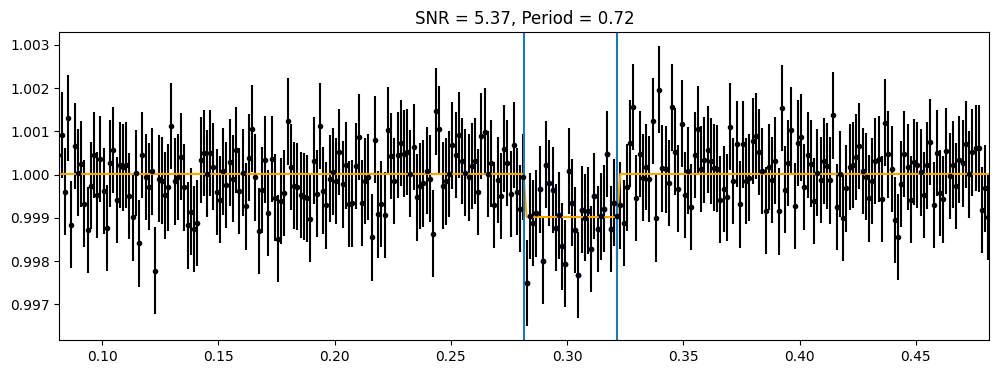

[<🌟 Lightcurve test_clean_bin_bls_0 (720t) 🌟>]

In [61]:
bls_targ = gp_smaller_binning.find_transits(minimum_period=0.5, maximum_period=10, transit_durations=np.linspace(0.01, 0.1, 10))
bls_targ

The recovered parameters look pretty close to the real ones (duration = 0.04, depth=0.005) with a decent SNR of 8.4!

(0.99, 1.01)

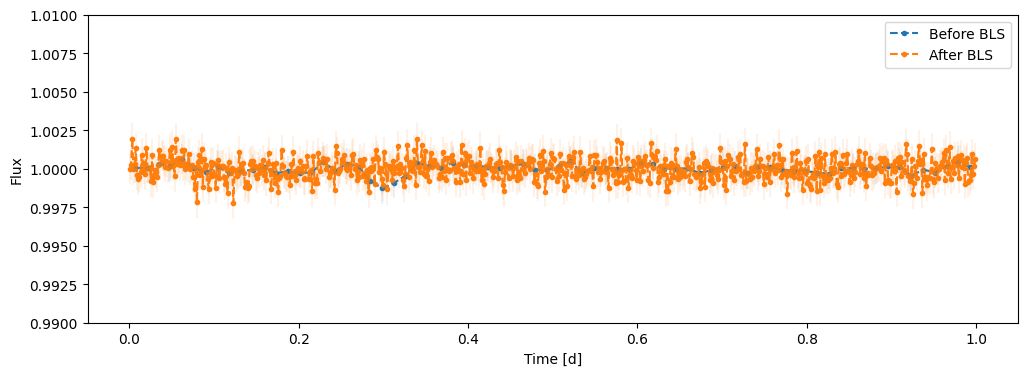

In [62]:
ax=gp_targ.plot(label="Before BLS", linestyle="--", color="C0")
bls_targ[0].plot(ax=ax, label="After BLS", linestyle="--", color="C1")
plt.ylim(0.99,1.01)

In [54]:
def find_transits_nuance(self, period, X, durations = np.linspace(0.01, 0.2, 15), plot=True):
    from nuance import Nuance
    from nuance.kernels import rotation
    import jax.numpy as jnp

    # optimize GP hyperparam
    nu = Nuance(self.time.jd, jnp.array(self.flux), error=self.uncertainty)#, X=X)
    build_gp, init_params = rotation(period=period)#, error=self.uncertainty)
    opt, mu, nll = nu.gp_optimization(build_gp=build_gp)
    opt_params = opt(init_params=init_params)
    rot_kernel = build_gp(params=opt_params, time=self.time.jd)

    nu = Nuance(self.time.jd, jnp.array(self.flux), gp=rot_kernel)#, X=X)

    epochs = self.time.jd.copy()
    nu.linear_search(epochs, durations)

    if plot:
        plt.subplot(211)
        plt.plot(self.time.jd, self.flux, ".", c="0.8")
        plt.ylabel("flux")
        plt.ylim(0.99,1.01)
        
        plt.subplot(212)
        nu.search_data.show_ll()
        plt.ylabel("durations")
        plt.xlabel("time")
        
        plt.tight_layout()
        plt.close()

        i, j = np.unravel_index(np.argmax(nu.search_data.ll), nu.search_data.ll.shape)
        t0, D = nu.search_data.t0s[i], nu.search_data.Ds[j]
        linear, astro, noise = nu.models(t0, D)
        plt.plot(self.time.jd, self.flux, ".", c="0.8")
        plt.plot(self.time.jd, linear + astro + noise, c="k", label="full model")
        plt.plot(
            self.time.jd,
            true["depth"] * utils.periodic_transit(self.time.jd, D=true["D"], t0=true["t0"]) + 1.0,
            ls="-",
            c="C0",
            label="injected",
        )
        plt.plot(self.time.jd, astro + 1.0, ls="--", c="k", label="found")
        plt.legend()
        plt.ylabel("flux")
        plt.xlabel("time")
        
        plt.tight_layout()
        print("\n".join([f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration"], [t0, D])]))

ScipyMinimizeInfo(fun_val=Array(-10858.31329386, dtype=float64, weak_type=True), success=False, status=2, iter_num=24, hess_inv=Array([[ 1.34935987e+05,  3.84611160e+04,  7.48026783e+03,
         5.66143825e+02,  6.11018107e+04, -8.35131340e+04,
        -4.90782452e+04, -1.77038067e+04, -3.49826463e+05],
       [ 3.84611160e+04,  1.09638024e+04,  2.13223491e+03,
         1.61370297e+02,  1.74162125e+04, -2.38041016e+04,
        -1.39889717e+04, -5.04619610e+03, -9.97126972e+04],
       [ 7.48026783e+03,  2.13223491e+03,  4.15845632e+02,
         3.13845008e+01,  3.38740109e+03, -4.62961982e+03,
        -2.72067692e+03, -9.81432926e+02, -1.93932009e+04],
       [ 5.66143825e+02,  1.61370297e+02,  3.13845008e+01,
         2.37558282e+00,  2.56362684e+02, -3.50393565e+02,
        -2.05912303e+02, -7.42775329e+01, -1.46775900e+03],
       [ 6.11018107e+04,  1.74162125e+04,  3.38740109e+03,
         2.56362684e+02,  2.76685379e+04, -3.78167352e+04,
        -2.22237819e+04, -8.01671171e+03, 

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0.301
duration: 0.051


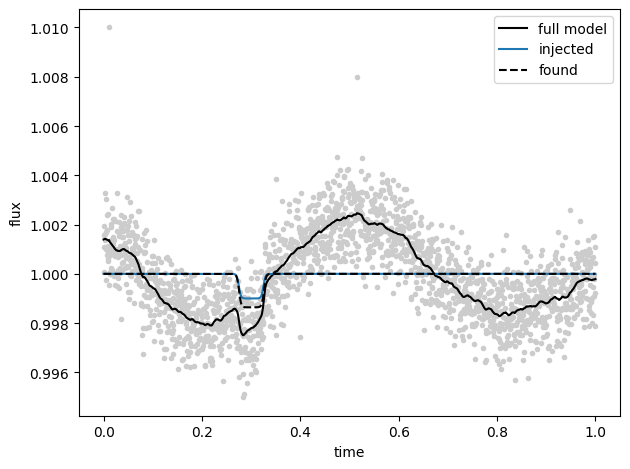

In [48]:
find_transits_nuance(targ, period=0.6, X=X)